# SF Airbnb Data Analysis

## Listing and Review Data Preparation

In [292]:
# Load necessary packages

import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

import gender_guesser.detector as gender
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import r2_score, confusion_matrix, classification_report, accuracy_score

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

import spacy
from spacy_langdetect import LanguageDetector

pd.set_option('display.max_columns', 999)

### Pre-process the listings data

In [3]:
# Load the listings data for the Airbnb Sanfrancisco area

listings_raw = pd.read_csv('listings.csv')

In [4]:
listings_raw.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,958,https://www.airbnb.com/rooms/958,20190806030527,2019-08-06,"Bright, Modern Garden Unit - 1BR/1B",New update: the house next door is under const...,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,none,*Quiet cul de sac in friendly neighborhood *St...,Due to the fact that we have children and a do...,*Public Transportation is 1/2 block away. *Ce...,*Full access to patio and backyard (shared wit...,A family of 4 lives upstairs with their dog. N...,* No Pets - even visiting guests for a short t...,NaN,NaN,https://a0.muscache.com/im/pictures/b7c2a199-4...,NaN,1169,https://www.airbnb.com/users/show/1169,Holly,2008-07-31,"San Francisco, California, United States",We are a family with 2 boys born in 2009 and 2...,within an hour,90%,NaN,t,https://a0.muscache.com/im/pictures/efdad96a-3...,https://a0.muscache.com/im/pictures/efdad96a-3...,Duboce Triangle,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"San Francisco, CA, United States",Lower Haight,Western Addition,NaN,San Francisco,CA,94117,San Francisco,"San Francisco, CA",US,United States,37.76931,-122.43386,t,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets liv...",NaN,$170.00,"$1,120.00","$4,200.00",$100.00,$100.00,2,$25.00,1,30,1,1,30,30,1.0,30.0,today,t,1,2,7,115,2019-08-06,199,46,2009-07-23,2019-07-19,97.0,10.0,10.0,10.0,10.0,10.0,9.0,t,STR-0001256,"{""SAN FRANCISCO""}",t,f,moderate,f,f,1,1,0,0,1.63
1,3850,https://www.airbnb.com/rooms/3850,20190806030527,2019-08-06,Charming room for two,Your own private room plus access to a shared ...,"This is the first room I rented on Airbnb, sta...",Your own private room plus access to a shared ...,none,"This is a quiet, safe neighborhood on a substa...",Here is the complete list of House Rules you a...,Public transit service to my house is outstand...,"During the hours of 7:00 to 22:00, your access...","I live at the house in my own bedroom, and I w...",These House Rules have money associated with t...,NaN,NaN,https://a0.muscache.com/im/pictures/b6e97d2a-1...,NaN,4921,https://www.airbnb.com/users/show/4921,Kevin,2008-12-08,"San Francisco, California, United States",I am a retired software entrepreneur now raisi...,with

In [5]:
# check the shape of the listings dataframe 

print(f'There are {listings_raw.shape[0]} listings and {listings_raw.shape[1]} features in the San Feancisco Airbnb listing data file.')

There are 7833 listings and 106 features in the San Feancisco Airbnb listing data file.


In [6]:
# Check if there are duplicate listings - no duplicate listings

listings_raw['id'].nunique()

7833

In [7]:
# List the column names that have null values

listings_raw.columns[listings_raw.isna().any()].tolist()

['summary',
 'space',
 'description',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'xl_picture_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'bathrooms',
 'bedrooms',
 'beds',
 'square_feet',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'license',
 'jurisdiction_names',
 'cancellation_policy',
 'review

In [9]:
# Subset to a dataframe that only holds relevant columns to answer the research questions which include:
# listing id, property/room type, minimum stay, host, price, and review related columns

listings = listings_raw[['id', 'property_type', 'room_type', 'price', 'minimum_nights', 
                         'host_id', 'host_since', 'host_is_superhost', 'host_listings_count', 'host_response_rate',   
                        'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
                        'review_scores_cleanliness', 'review_scores_checkin','review_scores_communication', 
                        'review_scores_location', 'review_scores_value', 'reviews_per_month']]

In [14]:
listings.head()

,id,property_type,room_type,price,minimum_nights,host_id,host_since,host_is_superhost,host_listings_count,host_response_rate,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,958,Apartment,Entire home/apt,$170.00,1,1169,2008-07-31,t,1.0,90%,199,97.0,10.0,10.0,10.0,10.0,10.0,9.0,1.63
1,3850,House,Private room,$99.00,1,4921,2008-12-08,t,2.0,100%,136,94.0,9.0,9.0,10.0,10.0,9.0,9.0,1.11
2,5858,Apartment,Entire home/apt,$235.00,30,8904,2009-03-02,f,2.0,67%,111,98.0,10.0,10.0,10.0,10.0,10.0,9.0,0.89
3,7918,Apartment,Private room,$65.00,32,21994,2009-06-17,t,10.0,100%,17,85.0,8.0,8.0,9.0,9.0,9.0,8.0,0.14
4,8142,Apartment,Private room,$65.00,32,21994,2009-06-17,t,10.0,100%,8,93.0,9.0,9.0,10.0,10.0,9.0,9.0,0.13


In [349]:
# Get Descriptive statistics

listings.drop(listings.iloc[:, 0:1], axis = 1).describe()

,minimum_nights,host_id,host_listings_count,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,price_rec,price_night,host_response_rate_rec,op_month
count,7.833000e+03,7.833000e+03,7832.000000,7833.000000,6226.000000,6222.000000,6223.000000,6220.000000,6224.000000,6220.000000,6220.000000,6275.000000,7833.000000,7721.000000,7042.000000,7832.000000
mean,1.278316e+04,5.479076e+07,80.686798,44.795608,95.601028,9.767117,9.625100,9.859325,9.835958,9.686174,9.403859,1.847225,217.160347,195.556534,96.232462,57.758938
std,1.129889e+06,7.171995e+07,281.468017,76.577321,7.222310,0.693223,0.804835,0.538277,0.607616,0.708233,0.828763,2.036818,279.523428,147.929092,11.932493,28.978746
min,1.000000e+00,4.600000e+01,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.010000,0.000000,10.000000,0.000000,0.000000
25%,2.000000e+00,4.191595e+06,1.000000,1.000000,95.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,0.300000,100.000000,100.000000,100.000000,36.000000
50%,4.000000e+00,2.034139e+07,2.000000,11.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.020000,153.000000,150.000000,100.000000,59.000000
75%,3.000000e+01,8.401186e+07,10.000000,54.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.800000,249.000000,240.000000,100.000000,80.000000
max,1.000000e+08,2.818842e+08,1465.000000,730.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,18.610000,9999.000000,999.000000,100.000000,137.000000


In [15]:
# Check the number of missing values for each variable

listings.isnull().sum().sort_values()

id                                0
property_type                     0
room_type                         0
price                             0
minimum_nights                    0
host_id                           0
number_of_reviews                 0
host_since                        1
host_is_superhost                 1
host_listings_count               1
host_response_rate              791
reviews_per_month              1558
review_scores_rating           1607
review_scores_communication    1609
review_scores_cleanliness      1610
review_scores_accuracy         1611
review_scores_checkin          1613
review_scores_location         1613
review_scores_value            1613
dtype: int64

In [16]:
# Check the data types of all columns

listings.dtypes

id                               int64
property_type                   object
room_type                       object
price                           object
minimum_nights                   int64
host_id                          int64
host_since                      object
host_is_superhost               object
host_listings_count            float64
host_response_rate              object
number_of_reviews                int64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float64
reviews_per_month              float64
dtype: object

In [13]:
# Check the property type values

listings.property_type.value_counts()

Apartment             3169
House                 2210
Condominium            839
Guest suite            555
Boutique hotel         235
Hotel                  156
Townhouse              141
Serviced apartment     130
Loft                    94
Hostel                  93
Guesthouse              43
Bed and breakfast       41
Aparthotel              30
Other                   28
Bungalow                18
Resort                  17
Cottage                  9
Villa                    9
Tiny house               3
Earth house              2
Boat                     2
Camper/RV                2
Cabin                    2
Dome house               1
Castle                   1
Timeshare                1
Vacation home            1
In-law                   1
Name: property_type, dtype: int64

In [212]:
# Recode the property types

def recode_property(x):
    '''
    This function recode the property types.
    'Apartment'='1', 'House'='2', 'Condominium/Townhouse'='3', and the rmaining types='4'
    
    Input = property type
    Output = recoded property type
    '''
    if x != None:
        if x == 'Apartment':
            return 'Apartment'
        elif x == 'House':
            return 'House'
        elif x == 'Condominium' or x =='Townhouse':
            return 'Condo/Townhouse'
        else:
            return 'Other'

In [213]:
listings['property_type_rec'] = listings['property_type'].apply(recode_property)

/Users/wolee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


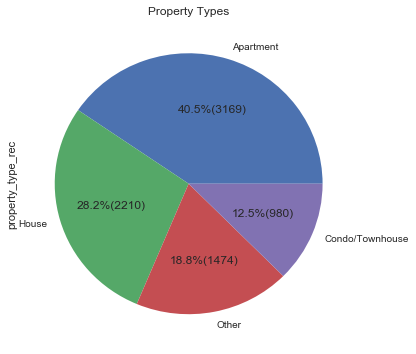

In [546]:
# Plot property types: apartments > houses > other types > condo/townhose  

ptypes = listings.property_type_rec.value_counts()
sns.set()
ptypes.plot(title = 'Property Types', figsize = [6,6], kind = 'pie', 
          autopct = lambda p: '{:.1f}%({:.0f})'.format(p,(p/100)*ptypes.sum()));

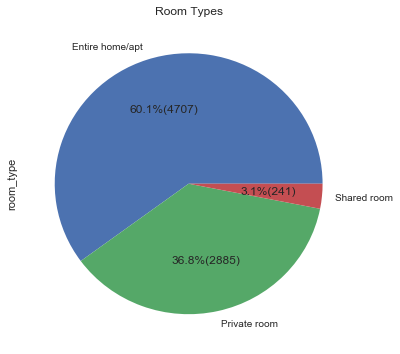

In [545]:
# Plot room types: entire property is most common

rtypes = listings.room_type.value_counts()

sns.set()
rtypes.plot(title = 'Room Types', figsize = [6,6], kind = 'pie', 
          autopct = lambda p: '{:.1f}%({:.0f})'.format(p,(p/100)*rtypes.sum()));

In [486]:
# Recode the super_host status column: t = superhost; f = non-superhost

listings['host_is_superhost'] = np.where(listings['host_is_superhost'] == 't', 'superhost', 'non-superhost') 

/Users/wolee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


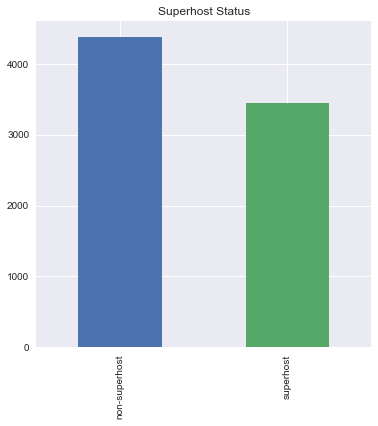

In [543]:
# Check the superhost values: superhost < non-superhost

# listings.host_is_superhost.value_counts().plot.bar();

shost = listings.host_is_superhost.value_counts()
sns.set()
shost.plot(title = 'Superhost Status', figsize = [6,6], kind = 'bar');

In [493]:
# Check the perentage of superhost

superhost_stat = listings.loc[listings.host_is_superhost == 'superhost']
superhost_percent = superhost_stat.shape[0]/listings.shape[0]*100
print(f'\nThe percentage of superhosts in San Francisco is {superhost_percent:.2f}%.')


The percentage of superhosts in San Francisco is 44.02%.


In [551]:
# Check the lengh of operation for superhost status: superhosts are in operation for 8 more months on average.

listings.groupby('host_is_superhost')['op_month'].mean()

host_is_superhost
non-superhost    54.351049
superhost        62.091937
Name: op_month, dtype: float64

In [221]:
# Recode the super_host status column: t = 1; f =0

listings['superhost'] = np.where(listings['host_is_superhost'] == 'superhost', '1', '0') 

/Users/wolee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/wolee/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


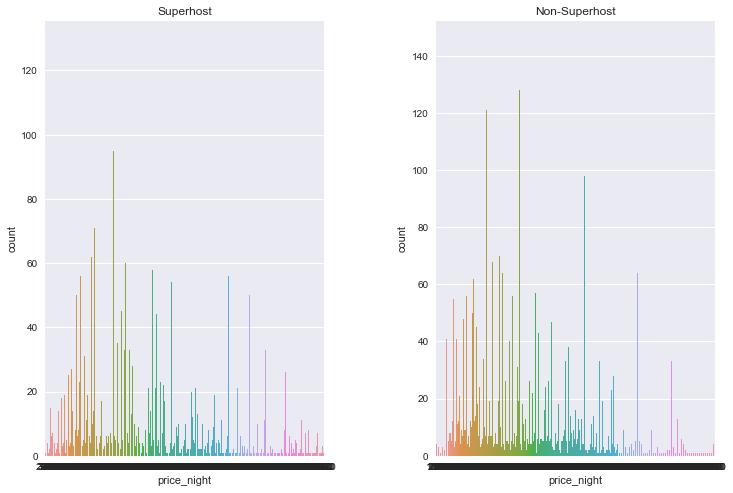

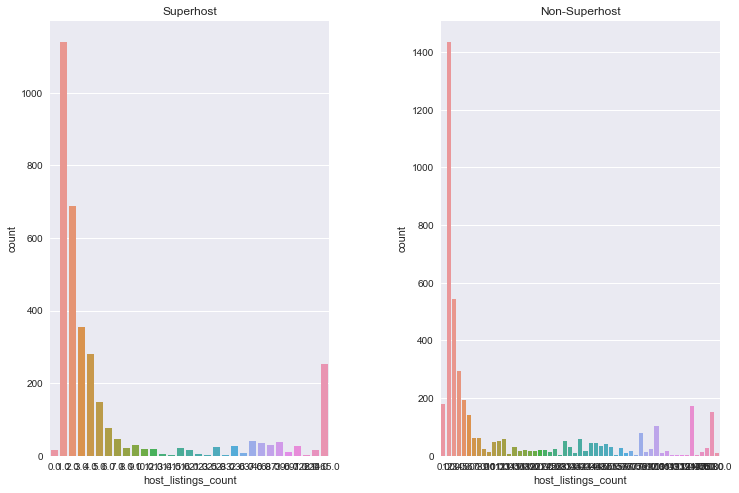

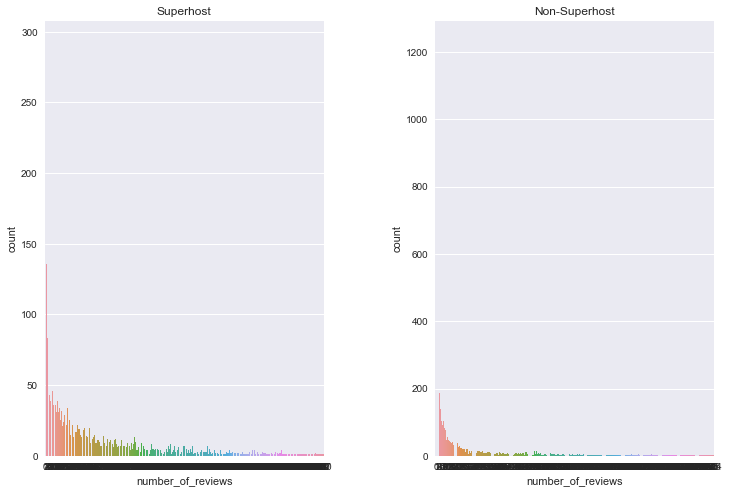

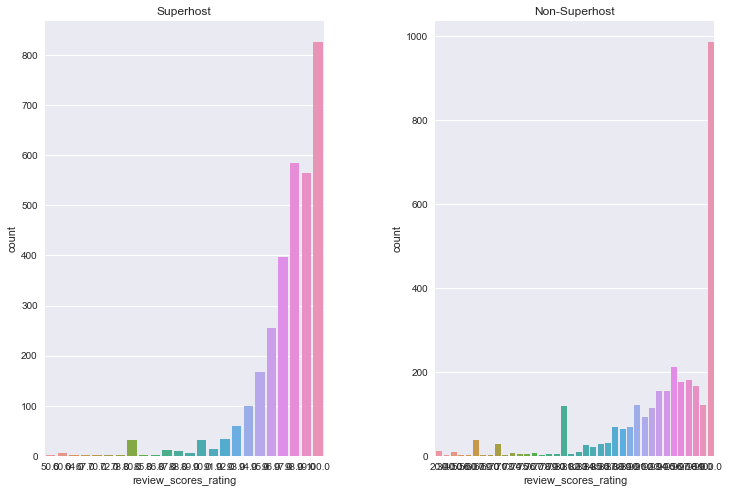

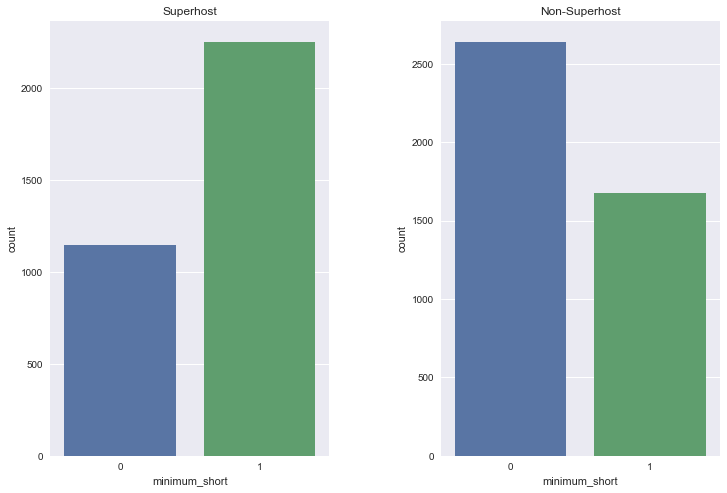

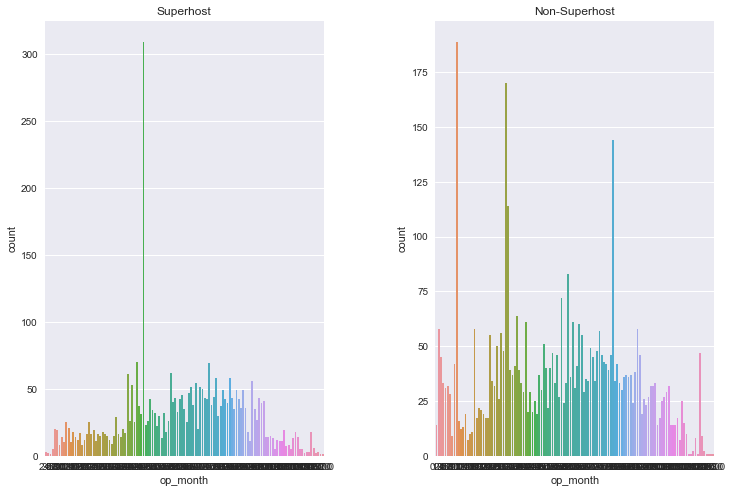

In [534]:
# Look at the differences in listings: superhosts vs non-superhosts
# In general, no dramatic differences except for the minium number of stays.
# Superhosts tend to have fewer number of minimum stays than non-superhosts.

super_df = listings_final.loc[listings_final.superhost == '1']
super_no_df = listings_final.loc[listings_final.superhost == '0']

# Compare the distribution of values for columns for differences in superhost and length of stay

def plot_subsets(df1, df2, columns):
    for c in columns:
        fig, ax = plt.subplots(1,2)
        sns.countplot(df1[c], ax = ax[0])
        sns.countplot(df2[c], ax = ax[1])
        ax[0].set_title('Superhost')
        ax[1].set_title('Non-Superhost')
        fig.subplots_adjust(wspace = 0.4)
        sns.set(rc = {'figure.figsize':(12, 8)})
        fig.show()
        
columns = ['price_night', 'host_listings_count', 'number_of_reviews','review_scores_rating', 'minimum_short', 'op_month']

plot_subsets(super_df, super_no_df, columns)

In [441]:
# Check values and outliers for the price column

# Recode price to int

listings['price_rec'] = listings['price'].replace('\D', '', regex = True).astype(int)
listings['price_rec'] = listings['price_rec']/100

# Find outliers that are outside the 3 SD. 
# Some prices listed appeared to be errors (e.g., $9,999 per night and $850 per week)

price_outlier = listings[(np.abs(stats.zscore(listings.price_rec)) > 3)]
print(f'The number of outliers for the price per night is {price_outlier.shape[0]}.\n')
# print(price_outlier.price_rec.value_counts())

# $1,000 looks like a good cut off value for outliers
price_outlier = listings.loc[listings.price_rec >= 1000]

# Get the percentage of outliers
outlier_percent = price_outlier.shape[0]/listings.price.shape[0]
print(f'\nThe percentage of outliers in the price column is {outlier_percent:.2f}%.')

# Recode these outliers as missing so they can be dropped in the next processing step

listings['price_night'] = listings['price_rec'].apply(lambda x: np.nan if x >= 1000 else x)

/Users/wolee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/wolee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


The number of outliers for the price per night is 87.


The percentage of outliers in the price column is 0.01%.


/Users/wolee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


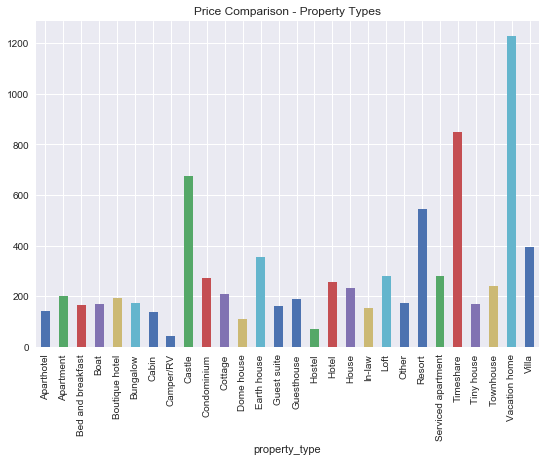

In [540]:
# Look at the raw prices across different propety types: 
# Vacation rental, Timeshare and castle are the most expensive property types but there is only one of each.

price_comp = listings.groupby('property_type')['price_rec'].mean()

sns.set()
price_comp.plot(title = 'Price Comparison - Property Types', figsize = [9,6], kind = 'bar');

In [61]:
# Check the number of null values in the recoded price column

print(f'{listings.price_night.isnull().sum()} listings with $1,000 or higher per night are excluded.\n${listings.price_night.mean():.2f} is the mean price per night excluding these outliers.')

110 listings with $1,000 or higher per night are excluded.
$195.51 is the mean price per night excluding these outliers.


In [224]:
# Get the range of price

listings.price_night.describe()

count    7723.000000
mean      195.505891
std       147.943404
min         0.000000
25%       100.000000
50%       150.000000
75%       240.000000
max       999.000000
Name: price_night, dtype: float64

In [242]:
# Look up the rows that have price of 0.
# There are two listings that has price of $0 for night.

listings.loc[listings.price_night == 0]

,id,property_type,room_type,price,minimum_nights,host_id,host_since,host_is_superhost,host_listings_count,host_response_rate,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,property_type_rec,superhost,price_rec,price_night,host_response_rate_rec,minimum_short,date_compiled,op_month
3871,20331804,Condominium,Private room,$0.00,4,17536951,2014-07-02,t,4.0,100%,26,96.0,10.0,10.0,10.0,10.0,10.0,9.0,1.13,Condo/Townhouse,1,0.0,0.0,100.0,1,2019-08-06,61.0
7757,37089599,Apartment,Entire home/apt,$0.00,1,143788000,2017-08-01,f,14.0,68%,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apartment,0,0.0,0.0,68.0,1,2019-08-06,24.0


In [228]:
# Recoded these listings' price as null. 

listings['price_night'] = listings['price_night'].apply(lambda x: np.nan if (id == 20331804 or id == 20331804) else x)

/Users/wolee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [243]:
listings['price_night'] = listings['price_night'].apply(lambda x: np.nan if x == 0 else x)

/Users/wolee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


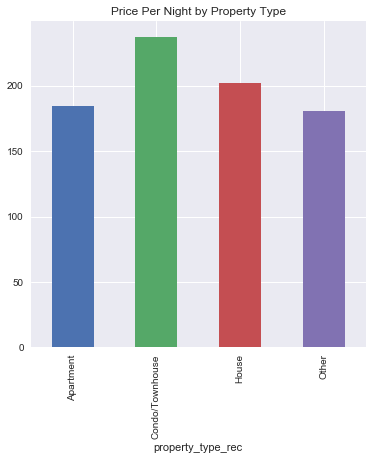

In [542]:
# Look at the prices across different propety types (recoded): Condo/townhouse is the most expensive property type 
# The mean price 

price_diff = listings.groupby('property_type_rec')['price_night'].mean()

sns.set()
price_diff.plot(title = 'Price Per Night by Property Type', figsize = [6,6], kind = 'bar');

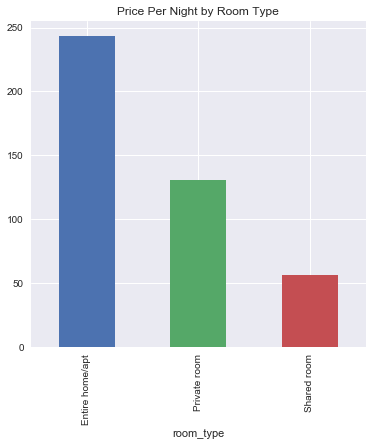

In [547]:
# Look at the prices across different room types is the most expensive property type: 
# As expected, the shared room type is the least expensive  

price_diff = listings.groupby('room_type')['price_night'].mean()

sns.set()
price_diff.plot(title = 'Price Per Night by Room Type', figsize = [6,6], kind = 'bar');

In [64]:
# Change the data type of the host_response_rate column from object to int 

listings['host_response_rate_rec'] = listings['host_response_rate'].dropna().replace('\D', '', regex = True).astype(int)

# Get the percentage of response rates that are 90% or higher 

response_rate = listings.loc[listings.host_response_rate_rec >= 90]
response_rate_percent = response_rate.shape[0]/listings.shape[0]*100

print(f'The percentage of host response rates that are 90% or higher is {response_rate_percent:.2f}%.')

The percentage of host response rates that are 90% or higher is 82.47%.


/Users/wolee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [142]:
# Check the top 5 response rates

listings.host_response_rate_rec.value_counts().head(5) 

100.0    5368
90.0      298
95.0      218
96.0      196
80.0      104
Name: host_response_rate_rec, dtype: int64

In [65]:
# Get top 5 most popular minimum nights required 

listings.minimum_nights.value_counts().sort_values(ascending = False).head(5)

30    3163
2     1512
1     1327
3      872
4      296
Name: minimum_nights, dtype: int64

In [339]:
# Get the percentage of listings with 1-4 minimum nights, excluding long-term stay _ about 50% of the raw data

listings_short = listings.loc[listings.minimum_nights < 5]
min_nights_percent = listings_short.shape[0]/listings.shape[0]*100
print(f'The percentage of listings that have 1-4 nights as minimum is {min_nights_percent:.1f}%.')

# Recode the number of minimum nights: 1 = 1-4 nights; 0 = more than 5 nights  

listings['minimum_short'] = np.where(listings.minimum_nights < 5, '1', '0')

The percentage of listings that have 1-4 nights as minimum is 51.2%.


In [340]:
# Calculate the length of operation by using the start date and the date this data was compiled which is August 6, 2019
# Change the data type to date from object

listings['date_compiled'] = '2019-08-06'

listings['date_compiled'] = pd.to_datetime(listings['date_compiled'], format='%Y-%m-%d')
listings['host_since'] = pd.to_datetime(listings['host_since'], format='%Y-%m-%d')

# Create a new column for the number of months since the host joined Airbnb
listings['op_month'] = (listings['date_compiled'] - listings['host_since'])/np.timedelta64(1, 'M')
listings['op_month'] = listings['op_month'].dropna().astype(int)

print(f'The average number of months hosts have been in operation is {listings.op_month.mean()/12:.1f} years.')

The average number of months hosts have been in operation is 4.8 years.


In [341]:
# Recode the listings based on whether or not they have reviews

listings['has_review'] = np.where(listings.review_scores_rating.isnull() == False, '1', '0') 

# Cehck the percentag of listings with no review scores

no_review_scores = listings_final.review_scores_value.isnull().sum()/listings_final.shape[0]*100

print(f'The percentage of listings that have no reviews is {no_review_scores:.1f}%')

The percentage of listings that have no reviews is 20.4%


/Users/wolee/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


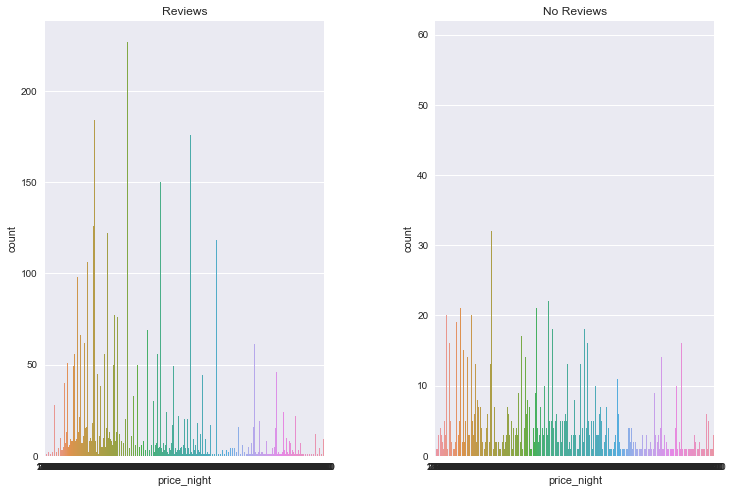

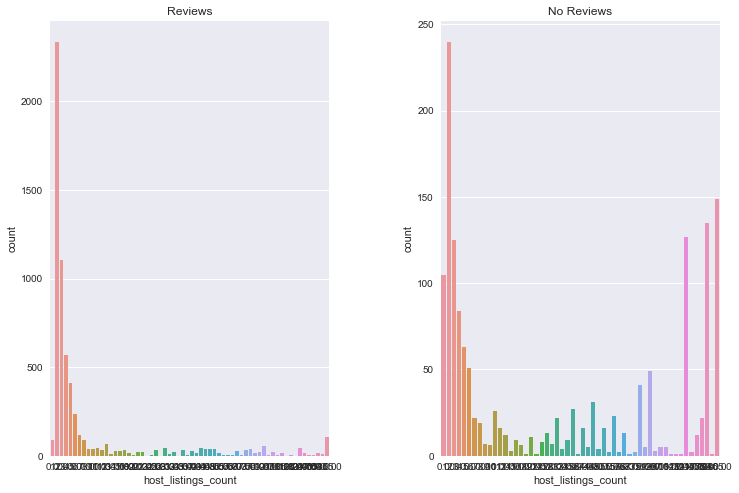

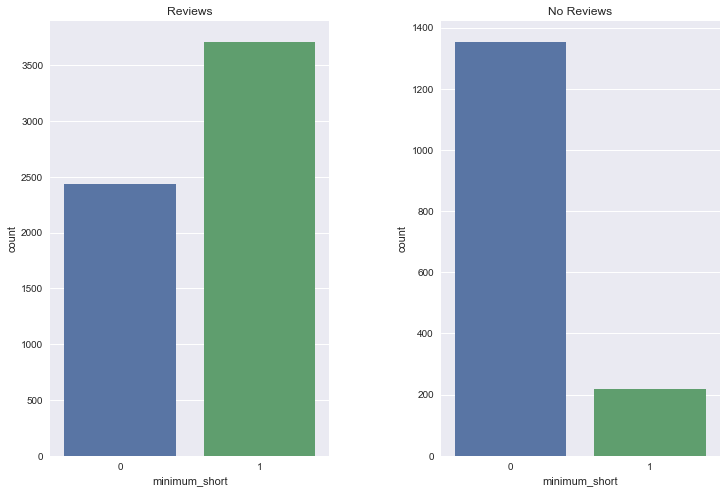

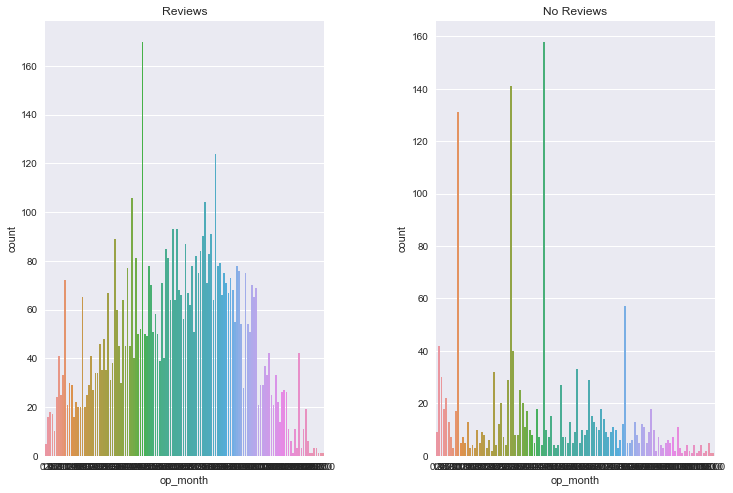

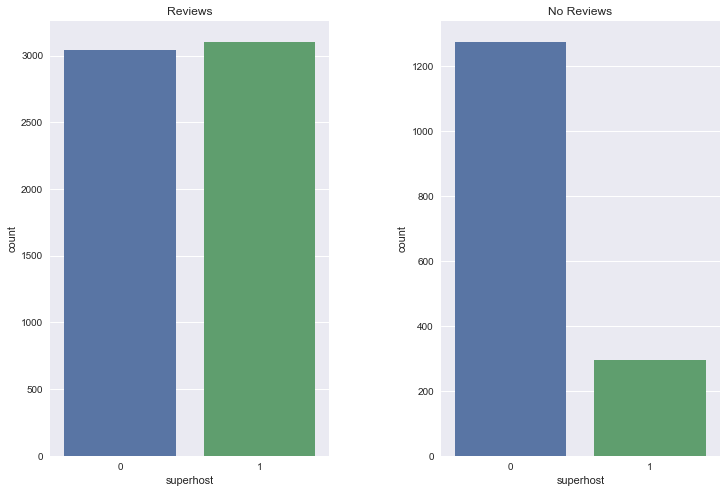

In [549]:
review_df = listings_final.loc[listings.has_review == '1']
review_no_df = listings_final.loc[listings.has_review == '0']

# Look at the differences in listings: reviews vs no reviews
# In general, there are differences between these two groups.

# Compare the distribution of values for columns for differences in superhost and length of stay

def plot_subsets(df1, df2, columns):
    for c in columns:
        fig, ax = plt.subplots(1,2)
        sns.countplot(df1[c], ax = ax[0])
        sns.countplot(df2[c], ax = ax[1])
        ax[0].set_title('Reviews')
        ax[1].set_title('No Reviews')
        fig.subplots_adjust(wspace = 0.4)
        sns.set(rc={'figure.figsize':(12, 8)})
        fig.show()
        
columns = ['price_night', 'host_listings_count', 'minimum_short', 'op_month', 'superhost']

plot_subsets(review_df, review_no_df, columns)

In [553]:
# Check the length of operation
# Listings with reviews on average has been in operation for a year longer.

listings.groupby('has_review')['op_month'].mean()

has_review
0    44.062850
1    61.294618
Name: op_month, dtype: float64

In [330]:
# Check the crosstab. 
# It looks like the listings with no reviews require longer term stays.

pd.crosstab(listings.minimum_short, listings.has_review)

has_review,0,1
minimum_short,,
0,1369,2457
1,238,3769


In [329]:
# Check the crosstab
# It is odd that there are superhosts with no reviews because review scores are one of the superhost criteria (4%)

pd.crosstab(listings.superhost, listings.has_review)

has_review,0,1
superhost,,
0,1294,3091
1,313,3135


In [333]:
# Drop columns that are not needed for anlaysis: Original columns that were recoded and listings with outliers

listings_final = listings.drop(['price', 'price_rec', 'host_since', 'host_is_superhost', 'minimum_nights', 'host_response_rate', 'date_compiled'],  axis=1)
listings_final = listings_final.loc[listings_final.price_night.isnull() == False]

In [334]:
listings_final.head()

,id,property_type,room_type,host_id,host_listings_count,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,property_type_rec,superhost,price_night,host_response_rate_rec,minimum_short,op_month,has_review
0,958,Apartment,Entire home/apt,1169,1.0,199,97.0,10.0,10.0,10.0,10.0,10.0,9.0,1.63,Apartment,1,170.0,90.0,1,132.0,1
1,3850,House,Private room,4921,2.0,136,94.0,9.0,9.0,10.0,10.0,9.0,9.0,1.11,House,1,99.0,100.0,1,127.0,1
2,5858,Apartment,Entire home/apt,8904,2.0,111,98.0,10.0,10.0,10.0,10.0,10.0,9.0,0.89,Apartment,0,235.0,67.0,0,125.0,1
3,7918,Apartment,Private room,21994,10.0,17,85.0,8.0,8.0,9.0,9.0,9.0,8.0,0.14,Apartment,1,65.0,100.0,0,121.0,1
4,8142,Apartment,Private room,21994,10.0,8,93.0,9.0,9.0,10.0,10.0,9.0,9.0,0.13,Apartment,1,65.0,100.0,0,121.0,1


In [338]:
# Get stats for numeric variables

listings_final.drop(listings_final.iloc[:, 0:4], axis = 1).describe()

,host_listings_count,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,price_night,host_response_rate_rec,op_month
count,7720.000000,7721.000000,6149.000000,6145.000000,6146.000000,6143.000000,6147.000000,6143.000000,6143.000000,6197.000000,7721.000000,6952.000000,7720.000000
mean,81.773705,45.282865,95.576191,9.766477,9.621868,9.858701,9.835367,9.684031,9.405014,1.861870,195.556534,96.244822,57.768523
std,283.351923,76.984303,7.236451,0.694788,0.808339,0.540353,0.608460,0.711320,0.829912,2.043019,147.929092,11.855744,28.999572
min,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.010000,10.000000,0.000000,0.000000
25%,1.000000,1.000000,95.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,0.310000,100.000000,100.000000,36.000000
50%,2.000000,11.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.050000,150.000000,100.000000,59.000000
75%,10.000000,56.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.820000,240.000000,100.000000,80.000000
max,1465.000000,730.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,18.610000,999.000000,100.000000,137.000000


In [264]:
listings_final.loc[listings_final.host_listings_count == 0]

The percentage of listings that have no reviews is 20.44%


In [269]:
# Get the shape of the final listing df

print(f'There are {listings_final.shape[0]} listings and {listings_final.shape[1]} features in the filnal listing dataframe.')

There are 7721 listings and 20 features in the filnal listing dataframe.


#### Examine the distribution and correlations among variables

In [270]:
# Get the list of columns that could be related. Note that price per night can actually fluctuate throughout the year

listings_cor = listings_final[['price_night', 'host_listings_count', 'number_of_reviews',
       'review_scores_rating', 'minimum_short', 'op_month']] 

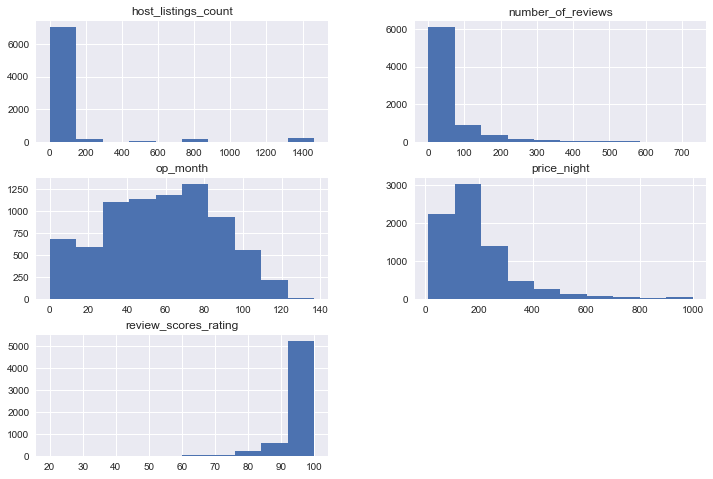

In [271]:
listings_cor.hist();

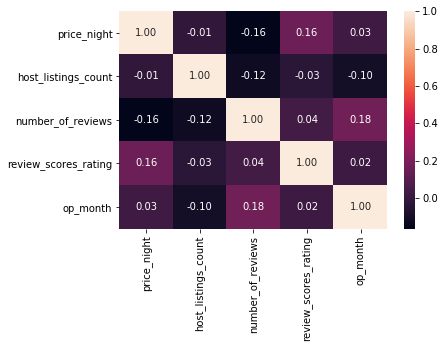

In [33]:
# Look at the heatmap of the features

sns.heatmap(listings_cor.corr(), annot = True, fmt = '.2f');

In [361]:
# Rename the id column in the listing_sub df to 'listing_id' to merge it with the reviews df

listings_final.rename(columns={'id': 'listing_id'}, inplace=True)

In [350]:
# save the cleaned listings file

listings_final.to_csv('airbnb_listings_cleaned_coded.csv')

### Pre-process the reviews data

In [81]:
# Load the reviews data for the Airbnb Sanfrancisco area

reviews_raw = pd.read_csv('reviews.csv')

In [82]:
reviews_raw.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st..."
1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...
2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...
3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...
4,958,26008,2010-02-13,15416,Venetia,Holly's place was great. It was exactly what I...


In [83]:
# check the shape of the listings dataframe 

print(f'There are {reviews_raw.shape[0]} reviews and {reviews_raw.shape[1]} features in the San Feancisco Airbnb review data file.')

There are 350884 reviews and 6 features in the San Feancisco Airbnb review data file.


In [84]:
# Check the null values

reviews_raw.isnull().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      1
comments         105
dtype: int64

In [85]:
reviews_raw.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st..."
1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...
2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...
3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...
4,958,26008,2010-02-13,15416,Venetia,Holly's place was great. It was exactly what I...


In [86]:
# Code gender of the reviewer using the gender guesser tool

gd = gender.Detector()

# for row in reviews_raw.reviewer_name:

reviews_raw['reviewer_gender'] = reviews_raw['reviewer_name'].apply(lambda x: gd.get_gender(x))

In [87]:
reviews_raw.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,reviewer_gender
0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st...",unknown
1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...,male
2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...,male
3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...,female
4,958,26008,2010-02-13,15416,Venetia,Holly's place was great. It was exactly what I...,female


In [88]:
reviews_raw.reviewer_gender.value_counts()

male             136199
female           132739
unknown           49238
mostly_female     13512
mostly_male       12510
andy               6686
Name: reviewer_gender, dtype: int64

In [93]:
# Get the percentage of each gender - about 84% are guessed as male or female

print(pd.DataFrame({'Percentage': reviews_raw.groupby('reviewer_gender').size() / reviews_raw.shape[0]}))

                 Percentage
reviewer_gender            
andy               0.019055
female             0.378299
male               0.388160
mostly_female      0.038508
mostly_male        0.035653
unknown            0.140326


In [54]:
# Check names classified as unknown

reviews_raw.loc[reviews_raw.reviewer_gender == 'unknown'].head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,reviewer_gender
0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st...",unknown
20,958,7817720,2013-10-04,8876124,Echo,What a gem! Holly (and her adorable son!) gree...,unknown
21,958,9049799,2013-12-03,7519331,Alfiani,We couldn't have asked for a better place to s...,unknown
22,958,12766593,2014-05-10,6745838,Toshi,Holly's garden unit is very nice. It is clean...,unknown
24,958,14349227,2014-06-17,3807407,Shaji,We visited San Fran for a mix of work and leis...,unknown


In [55]:
# Check names classified as andy (androgynous) which could be male and female

reviews_raw.loc[reviews_raw.reviewer_gender == 'andy'].head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,reviewer_gender
130,958,243671073,2018-03-16,135307957,Cheng,Great location with public transport and a par...,andy
142,958,279458208,2018-06-20,47298186,Bin,This is lovely private space that you can find...,andy
152,958,301782825,2018-08-04,109096226,Dominique,Nous avons beaucoup apprécié notre séjour chez...,andy
270,3850,13229775,2014-05-22,8996947,Yu,"The room is clean, cozy and the price is good....",andy
300,3850,19690948,2014-09-16,7900195,Lesley,Kevin is a great hosts. Very nice and helpful....,andy


In [423]:
# Recode mostly male to male to 'male' and mostly female to femal2 to 'female' 
# Convert unknown and andy to null values.
# Note there could be errors in gender determination.

reviews_raw['reviewer_gender_rec'] = reviews_raw.reviewer_gender.apply(lambda x: 'male' if (x == 'male' or x == 'mostly_male')  else 'female' if (x == 'female' or x == 'mostly_female') else np.nan) 

In [424]:
reviews_raw.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,reviewer_gender,reviewer_gender_rec
0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st...",unknown,NaN
1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...,male,male
2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...,male,male
3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...,female,female
4,958,26008,2010-02-13,15416,Venetia,Holly's place was great. It was exactly what I...,female,female


In [425]:
# Drop the rows with no reviwer name, reviews, or gender information

reviews = reviews_raw.dropna()
print(f'There are {reviews.shape[0]} reviews and {reviews.shape[1]} features in the cleaned San Feancisco Airbnb review data file.')

There are 294869 reviews and 8 features in the cleaned San Feancisco Airbnb review data file.


In [426]:
# Check the gender breakdown in the number of reviews posted - slightly higher number of males

reviews.groupby('reviewer_gender_rec').size().reset_index(name='gender')

,reviewer_gender_rec,gender
0,female,146218
1,male,148651


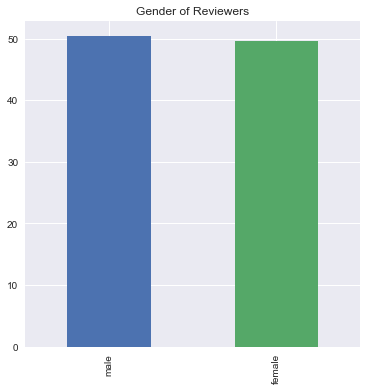

In [557]:
# Check the gender breakdown in the number of reviews posted - roughly equal number of males and females

rgender = reviews.reviewer_gender_rec.value_counts(normalize=True)*100

sns.set()
rgender.plot(title = 'Percentage of Gender of Reviewers', figsize = [6,6], kind = 'bar');

In [429]:
# Check the number of people who posted reviews

reviewer_num = reviews.reviewer_id.nunique()

print(f'There are {reviewer_num} people who posted reviews or gave ratings in the cleaned San Feancisco Airbnb review data file.')

There are 262560 people who posted reviews or gave ratings in the cleaned San Feancisco Airbnb review data file.


#### Examine the gender difference in the number of reviews posted

In [431]:
reviews_mult = pd.concat(g for _, g in reviews.groupby('reviewer_id') if len(g) > 1)
reviews_mult.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,reviewer_gender,reviewer_gender_rec
28153,288213,12989859,2014-05-16,1,Nathan,We had a great experience. The apartment was c...,male,male
90712,1855096,11373365,2014-03-31,1,Nathan,Mike was super responsive in his communication...,male,male
113772,2933105,13169732,2014-05-20,1,Nathan,My stay with Michelle and her family was perfe...,male,male
1281,9225,3522757,2013-02-11,3,Brian,Staying here was like sleeping in a gallery. T...,male,male
2156,12522,62892,2010-07-09,3,Brian,Staying with Brenda was an amazing experience....,male,male


In [108]:
# Check the number of people who posted more than 1 review

reviewer_mult_num = reviews_mult.reviewer_id.nunique()

print(f'There are {reviewer_mult_num} people who posted reviews or gave ratings more than once in the cleaned San Feancisco Airbnb review data file.')

There are 20136 people who posted reviews or gave ratings more than once in the cleaned San Feancisco Airbnb review data file.


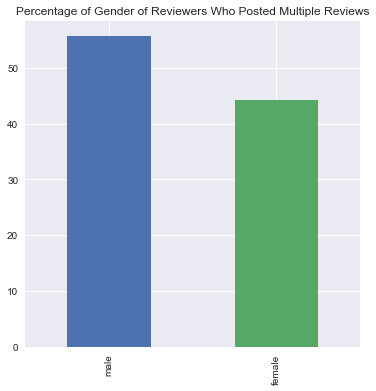

In [558]:
# Check gender breakdown among people who posted multiple reivews - higher percentage of males

rgender = reviews_mult.reviewer_gender_rec.value_counts(normalize=True)*100

sns.set()
rgender.plot(title = 'Percentage of Gender of Reviewers Who Posted Multiple Reviews', figsize = [6,6], kind = 'bar');

In [434]:
# Calculate the number of reviews for each reviewer and get top 10 reviewers
# Two people wrote more than 50 reviews!

reviews.groupby(['reviewer_id', 'reviewer_gender_rec']).size().sort_values(ascending = False).reset_index(name='counts').head(10) 

,reviewer_id,reviewer_gender_rec,counts
0,2895282,female,78
1,24713363,male,51
2,49656450,male,39
3,2442976,male,36
4,507125,male,34
5,45970431,male,31
6,21186995,male,27
7,148862477,male,25
8,3259215,female,23
9,46640957,male,23


In [ ]:
# Recode the gender into 1 = 'male' and 2 = female for analysis

reviews['reviewer_gender_rec'] = reviews.reviewer_gender_rec.apply(lambda x: '1' if (x == 'male') else '0' if (x == 'female' ) else np.nan) 

#### Clean the review text

In [118]:
# Identify reviews that are not written in English.
# Initialize the spacy nlp object

nlp = spacy.load("en")
nlp.add_pipe(LanguageDetector(), name="language_detector", last = True)

In [76]:
# Get the language of the reviews

def lang_detector(review):
    '''
    This function determins in which language the commentes are written.
    
    Input: review
    Output: language
    '''
    text = nlp(review)
    return text._.language['language']

In [77]:
# Create the language column, measure the elapsed time 

# This process is very slow. Parallelize to speed up.

from dask import dataframe as dd

start = time.time()

reviews['language'] = dd.from_pandas(reviews,npartitions=8).\
map_partitions(lambda df : df['comments'].\
               apply(lambda x : lang_detector(x))).\
compute(scheduler='processes')

end = time.time()
print (f'The elapsed time for coding the language for all reviews is {(end - start)/60:.2f}.')

The elapsed time for coding the language for all reviews is 776.25.


/Users/wolee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [80]:
# Look at the reviews that are not written in English

reviews_foreign = reviews.loc[reviews.language != 'en']
reviews_foreign

,listing_id,id,date,reviewer_id,reviewer_name,comments,reviewer_gender,reviewer_gender_rec,language
30,958,20751295,2014-10-05,19405174,Inger,Vi bodde väldigt bra hos Holly! Vi blev väl mo...,female,0.0,sv
33,958,39423363,2015-07-23,24284061,Gabriela,Una parte muy importante de cada viaje es el l...,female,0.0,es
62,958,106753136,2016-10-07,26548579,Miguel,El barrio y la ubicación es inmejorable!\r\nHo...,male,1.0,es
79,958,139292569,2017-03-24,1910464,Isolina,.,female,0.0,UNKNOWN
88,958,156890165,2017-06-01,64622286,Thea,Perfekt sted å bo i San Francisco! Kort vei ti...,female,0.0,no
100,958,180175634,2017-08-09,9792924,Elise,Une super jolie maison dans le plus beau quart...,female,0.0,fr
105,958,186493212,2017-08-24,90766418,Ute,Ein sehr wohnliches und großzügig ausgestattet...,female,0.0,de
107,958,191204168,2017-09-06,3061494,Xavier,Très bon séjour chez Holly. L'appartement est ...,male,1.0,fr
113,958,202530818,2017-10-11,149834425,Kjell,Bra boende i trevligt bostadsområde med lokalb...,male,1.0,da
125,958,237950593,2018-02-24,20166310,Fernando,El apartamento esta exactamente en las condici...,male,1.0,es


In [84]:
# Get the percentage of written in English - Please note that this is not 100% accurate. 
# The reviews that are classified as not being written in English actually included reviews written in English.
# It is possible that the opposite is true but the percentage is very small.

reviews_foreign_percent = reviews_foreign.shape[0]/reviews['comments'].shape[0]
print(f'\nThe percentage of reviews that are not written in English in the comments column is {reviews_foreign_percent:.2f}.')


The percentage of reviews that are not written in English in the comments column is 0.06.


In [87]:
# Remove non-English reviews for sentiment analysis

reviews_final = reviews.loc[reviews.language == 'en']

## Data Analyses

### Regression Analysis

In [411]:
# Create a dataframe that contains host-related variables.
# 'host_response_rate_rec' is exluded due to low variability and high correlation with superhost status
# Thsse do not include any null values.

listings_host = listings_final[['price_night', 'superhost', 'host_response_rate_rec','host_listings_count', 'minimum_short', 'op_month',  
                                'room_type', 'number_of_reviews', 'reviews_per_month','review_scores_rating']] 

In [365]:
# Check missing value percentages.
# The percentages of missing values are small except for the review related category.

(listings_final.isnull().sum()/listings_final.shape[0])*100

listing_id                      0.000000
property_type                   0.000000
room_type                       0.000000
host_id                         0.000000
host_listings_count             0.012952
number_of_reviews               0.000000
review_scores_rating           20.360057
review_scores_accuracy         20.411864
review_scores_cleanliness      20.398912
review_scores_checkin          20.437767
review_scores_communication    20.385960
review_scores_location         20.437767
review_scores_value            20.437767
reviews_per_month              19.738376
property_type_rec               0.000000
superhost                       0.000000
price_night                     0.000000
host_response_rate_rec          9.959850
minimum_short                   0.000000
op_month                        0.012952
has_review                      0.000000
dtype: float64

In [404]:
# Convert categorical variables to dummy variables and impute means for numeric variables
# The missing values occur for the review-related varaibles which will be removed
# because the depenent variable is review scores.
# It will be okay to impute means for the remaining numeric variables that have a small number of missing values.

def clean_df(df, response_col):
    '''
    This function impute missing values and create dummy variables for categorical variables.
    
    INPUT:
    df - dataframe that holds the variables of interest
    response_col - column name for the response variable
    
    OUTPUT:
    X - X matrice that holds all the variables of interest (predictors)
    y - vector that holds the response variable (outcome)
    '''

# Drop nan values in the response column
    df  = df.dropna(subset=[response_col], axis=0)
        
    # Create dummy vars for categorical vars - no dummy for null values
    cat_col = df.select_dtypes(include=['object']) 
    for col in cat_col:
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
    
    
    # Impute means for null values for numeric variables 
    fill_mean = lambda col: col.fillna(col.mean())
    df = df.apply(fill_mean, axis=0)
        
    # Split into explanatory and response variables
    X = df.drop(response_col, axis=1) # matrix    
    y = df[response_col] # vector response
    
    return X, y

In [412]:
# Create predictor and outcome variables - host-related variables

X, y = clean_df(listings_host, 'review_scores_rating') 

In [140]:
# Build a regression model with the following as predictors: 
# price, host length, super host status, minimum stay, number of reviews 

def reg_model(X, y, test_size, rand_state):
    ''' 
    INPUT:
    X - X matrice that holds all the variables of interest (predictors)
    y - vector that holds the response variable (outcome)
    test_size - a float that ranges from 0 to 1 indicating the proportion of data for the test dataset
    rand_state - an int indicating the random state for splitting the data into training and test dataset
    
    OUTPUT:
    X_train, X_test, y_train, y_test - output from sklearn train test split used for the linear regression model
    lm_model - model object from sklearn
    train_score - float - r2 score on the test data
    test_score - float - r2 score on the test data
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = rand_state)

    lm_model = LinearRegression(normalize = True)
    lm_model.fit(X_train, y_train)
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return X_train, X_test, y_train, y_test, lm_model, train_score, test_score

In [413]:
# Run the regression model - scores are low

X_train, X_test, y_train, y_test, lm_model, l_train_score, l_test_score = reg_model(X, y, 0.3, 42)
print(l_train_score, l_test_score)

0.11621462054256815 0.08068008534457938


In [394]:
# coefficients - adopted from the Udacity course matrials

def coef_weights(coefficients, X_train, lm_model):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending = False)
    return coefs_df

In [414]:
# Get coefficients of each variable that predicts review scores
# Superhost status is the strongest predictor, followed by the shared room type (lowest price). 
# Shorter minimum stay is also realted to high reviews ratings but it may be related to superhost status too.
# Other host related variables as well as price didn't predict review ratings. 

coef_df = coef_weights(lm_model.coef_, X_train, lm_model)

coef_df.sort_values('abs_coefs', ascending = False)

,est_int,coefs,abs_coefs
6,superhost_1,3.718705,3.718705
9,room_type_Shared room,-3.636972,3.636972
7,minimum_short_1,1.316840,1.316840
8,room_type_Private room,-0.691945,0.691945
5,reviews_per_month,0.064930,0.064930
1,host_response_rate_rec,0.006967,0.006967
0,price_night,0.005493,0.005493
4,number_of_reviews,-0.003679,0.003679
2,host_listings_count,-0.002043,0.002043
3,op_month,0.001905,0.001905


In [371]:
# Add reviews data and see if gender and sentiment can predict review scores 
# Merge the listings and reviews dataframes

listings_merged = pd.merge(listings_final, reviews_final, on = 'listing_id', how = 'left')

,listing_id,property_type,room_type,host_id,host_listings_count,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,property_type_rec,superhost,price_night,host_response_rate_rec,minimum_short,op_month,has_review,Unnamed: 0,id,date,reviewer_id,reviewer_name,comments,reviewer_gender,reviewer_gender_rec,language,sentiment_score,sentiment,comments2
0,958,Apartment,Entire home/apt,1169,1.0,199,97.0,10.0,10.0,10.0,10.0,10.0,9.0,1.63,Apartment,1,170.0,90.0,1,132.0,1,1.0,6660.0,2009-08-03,26145.0,Simon,Returning to San Francisco is a rejuvenating t...,male,1.0,en,0.9819,positive,"[returning, san, francisco, rejuvenating, thri..."
1,958,Apartment,Entire home/apt,1169,1.0,199,97.0,10.0,10.0,10.0,10.0,10.0,9.0,1.63,Apartment,1,170.0,90.0,1,132.0,1,2.0,11519.0,2009-09-27,25839.0,Denis,We were very pleased with the accommodations a...,male,1.0,en,0.7600,positive,"[pleased, accommodations, friendly, neighborho..."
2,958,Apartment,Entire home/apt,1169,1.0,199,97.0,10.0,10.0,10.0,10.0,10.0,9.0,1.63,Apartment,1,170.0,90.0,1,132.0,1,3.0,16282.0,2009-11-05,33750.0,Anna,We highly recommend this accomodation and agre...,female,0.0,en,0.9840,positive,"[highly, recommend, accomodation, agree, previ..."
3,958,Apartment,Entire home/apt,1169,1.0,199,97.0,10.0,10.0,10.0,10.0,10.0,9.0,1.63,Apartment,1,170.0,90.0,1,132.0,1,4.0,26008.0,2010-02-13,15416.0,Venetia,Holly's place was great. It was exactly what I...,female,0.0,en,0.9617,positive,"[holly's, place, great., exactly, needed., , p..."
4,958,Apartment,Entire home/apt,1169,1.0,199,97.0,10.0,10.0,10.0,10.0,10.0,9.0,1.63,Apartment,1,170.0,90.0,1,132.0,1,5.0,29240.0,2010-03-13,78623.0,Mathieu,"On top of all that has been said previously, I...",male,1.0,en,0.9884,positive,"[top, said, previously,, would, add, quiet, pl..."


In [397]:
# Create a dataframe that contains different review categories 

listings_reviews = listings_merged[['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                                   'review_scores_communication', 'review_scores_location','review_scores_value', 
                                   'reviewer_gender_rec', 'sentiment_score', 'sentiment','review_scores_rating']]

# listings_reviews = listings_merged[['reviewer_gender_rec', 'sentiment_score', 'sentiment','review_scores_rating']]

In [398]:
# Drop all null values since there are not many missing values left
# after removing missing values for the dependent variable - review scores rating

listings_reviews = listings_reviews.dropna()

In [399]:
# Create predictor and outcome variables - review-related variables

X1, y1 = clean_df(listings_reviews, 'review_scores_rating') 

In [400]:
X1_train, X1_test, y1_train, y1_test, lm_model1, l_train_score1, l_test_score1 = reg_model(X1, y1, 0.3, 42)
print(l_train_score1, l_test_score1)

0.6659849267002742 0.6738216090078516


In [401]:
# Get coefficients of each variable that predicts review scores
# Cleanliness, accuracy of places, and communication were top three predictors of review scores.

coef_df1 = coef_weights(lm_model1.coef_, X1_train, lm_model1)

coef_df1.sort_values('abs_coefs', ascending = False)

,est_int,coefs,abs_coefs
1,review_scores_cleanliness,2.432551,2.432551
0,review_scores_accuracy,2.100924,2.100924
3,review_scores_communication,1.956996,1.956996
5,review_scores_value,1.680932,1.680932
7,sentiment_score,1.343493,1.343493
4,review_scores_location,0.850467,0.850467
2,review_scores_checkin,0.712761,0.712761
9,sentiment_positive,-0.643456,0.643456
8,sentiment_neutral,0.288258,0.288258
6,reviewer_gender_rec,0.046245,0.046245


### Sentiment analysis

In [353]:
# Initialize the sentiment intensity analyzer

sia = SentimentIntensityAnalyzer()

# Get the compound score

def sent_score(review):
    '''
    This function generates the positive/negatrive sentiment scores.
    
    Input: review
    Output: compound sentiment score
    '''
    
    score = sia.polarity_scores(review)['compound']
    return score

In [356]:
# Compute the compound score for positive/negative sentiment in reviews

reviews_final['sentiment_score'] = reviews_final['comments'].apply(sent_score)

# Code for positive vs negative sentiment 

reviews_final['sentiment'] = reviews_final['sentiment_score'].apply(lambda x: 'positive' if x > 0 else 'neutral' 
                                                                    if x==0 else 'negative')

In [357]:
# Get the percentages of positive vs negative sentiment reviews. 
# Nearly everyone gave positive reviews!

reviews_final['sentiment'].value_counts(normalize=True)*100

positive    97.831456
neutral      1.249572
negative     0.918973
Name: sentiment, dtype: float64

In [366]:
# Examine negative reviews. Again, this is not 100% accurate.

reviews_neg = reviews_final.loc[reviews_final.sentiment == 'negative'] # Many are written in non-English.

reviews_neg

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,reviewer_gender,reviewer_gender_rec,language,sentiment_score,sentiment,comments2
507,634,8739,882824,2012-01-25,1382693,Betsy,I had to cancel last minute due to an emergenc...,female,0.0,en,-0.3802,negative,"[cancel, last, minute, due, emergency, home,, ..."
1145,1397,9225,31088287,2015-05-01,4429669,Mike,"Easy parking - rare in SFO, and lots of art. \...",male,1.0,en,-0.8870,negative,"[easy, parking, -, rare, sfo,, lots, art., how..."
1160,1416,9225,37831399,2015-07-11,12979864,David,Artful Potero Hill appartment for the guests i...,male,1.0,en,-0.9507,negative,"[artful, potero, hill, appartment, guests, ful..."
1359,1664,9225,407031613,2019-01-31,229461613,Stephan,Lots of art. May be distracting to some.,male,1.0,en,-0.2960,negative,"[lots, art., may, distracting, some.]"
1395,1707,9225,483808708,2019-07-07,44040145,Galina,Very unpleasant place to stay in descent neigh...,female,0.0,en,-0.7316,negative,"[unpleasant, place, stay, descent, neighborhoo..."
1466,1781,10251,763963,2011-12-05,422514,Grant,These guys get what a vacation rental should b...,male,1.0,en,-0.4215,negative,"[guys, get, vacation, rental, be., towels,, pl..."
1741,2118,10824,258211024,2018-04-28,121431922,Victor,"Place is in a great location, and for simple i...",male,1.0,en,-0.8064,negative,"[place, great, location,, simple, inquiries, b..."
1749,2127,10832,30574420,2015-04-24,30437873,Stephanie,Overall a good stay. Location is right in unio...,female,0.0,en,-0.6707,negative,"[overall, good, stay., location, right, union,..."
1997,2416,12522,46364653,2015-09-10,28953755,Joan,Brenda and I had some communication problems t...,female,0.0,en,-0.6440,negative,"[brenda, communication, problems, bnb, site,, ..."
2245,2703,18231,175887,2011-01-29,53416,Gena,The space was clean and nicely updated with a ...,female,0.0,en,-0.9267,negative,"[space, clean, nicely, updated, thoughtful, bo..."


In [359]:
# An example of reviews that is inaccurately classified as "negative" 

reviews_neg.comments.iloc[12] #wrong label

"We had a fantastic stay in the studio. Every need was met. This was our very first time in San Francisco and we could not have picked a better location away from the hustle and bustle.  The parking was ample for a Golf TDI, and access to public transportation was just a block away.  \r\n\r\nIf you wake up hungry check out Savor.  It's a short walk, and IMO it was better than Toast!"

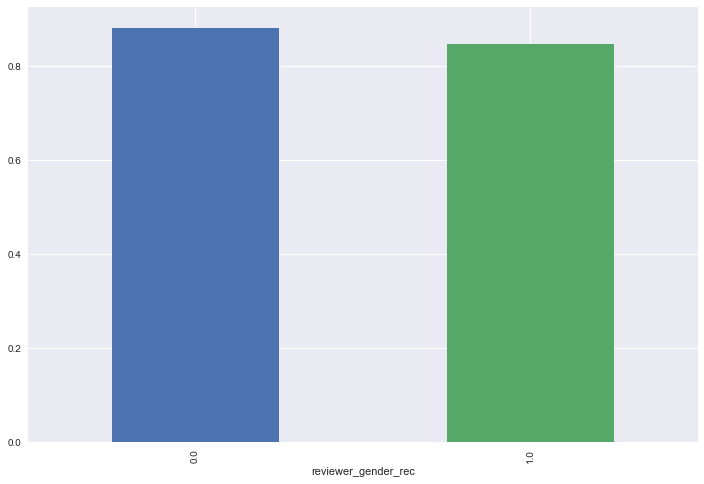

In [367]:
# Look at the gender differences in sentiment scores - not much difference

reviews_final.groupby('reviewer_gender_rec')['sentiment_score'].mean()
sent_diff = reviews_final.groupby('reviewer_gender_rec')['sentiment_score'].mean()
sent_diff.plot.bar();

In [439]:
# Look at the gender differences in sentiment scores - not much difference

pd.crosstab(reviews_final.reviewer_gender_rec, reviews_final.sentiment)

sentiment,negative,neutral,positive
reviewer_gender_rec,,,
0.0,1125,1474,134806
1.0,1424,1992,136554


In [ ]:
# Save the cleaned/coded reviews file

reviews_final.to_csv('airbnb_reviews_cleaned_coded.csv')

### Text analysis

In [469]:
# Remove the stopwords from the reviews 

stop_words = set(stopwords.words('english')) 

reviews_final['comments2'] = reviews_final['comments'].apply(lambda x: [item.strip().lower() for item in x.split(' ') if item.strip().lower() not in stop_words])

# Merge the sublist that contains each review in the big list to create a corpus of words

review_list = reviews_final['comments2'].values.tolist()
flat_list = [item for sublist in review_list for item in sublist]

In [470]:
# Initialize a CountVectorizer object: count_vectorizer - from Kaggle tutorial

count_vec = CountVectorizer(stop_words = "english", analyzer = 'word', 
                            ngram_range = (1, 1), max_df = 1.0, min_df = 1, max_features = None)

# Transforms the data into a bag of words

count_train = count_vec.fit(flat_list)
bag_of_words = count_vec.transform(flat_list)

In [457]:
# Check the number of words

print(f'There are {len(count_train.vocabulary_)} vocabularies in the review text excluding the stopwords.')

There are 48582 vocabularies in the review text excluding the stopwords.


In [480]:
# Initialize the tfidf vectorizor objsect

tf = TfidfVectorizer(smooth_idf = False, sublinear_tf = False, norm = None, analyzer = 'word')
txt_fitted = tf.fit(flat_list)
txt_transformed = txt_fitted.transform(flat_list)

In [ ]:
# Get the inverse documnet frequency

idf = tf.idf_

In [477]:
# Subset the reviews data 

X2 = reviews_final['comments']
y2 = reviews_final['reviewer_gender_rec']

# To test if comments can predict gender

def classify_text(X, y):
    '''
    This function displays the classification report for the Linear SVC model.
    
    Input: 
    X - X matrice that holds the variables of interest (predictors)
    y - vector that holds the response variable (outcome)
    
    Output:
    classification report that shows precision, recall, f1-score, and support
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])
    text_clf.fit(X_train, y_train)
    preds = text_clf.predict(X_test)
    preds = text_clf.predict(X_test)
    c_report = classification_report(y_test, preds)
    print(f'Classificstion Report\n\n{c_report}')

In [478]:
# classify gender based on reviews - prediction not great
# It would be great that there are actual demographic data of reviewers

classify_text(X2, y2)

Classificstion Report

             precision    recall  f1-score   support

        0.0       0.65      0.63      0.64     41252
        1.0       0.65      0.67      0.66     41961

avg / total       0.65      0.65      0.65     83213



In [484]:
# Get the most common words in the reviews
# Code is from https://gist.github.com/CristhianBoujon/c719ba2287a630a6d3821d37a9608ac8

def get_top_n_words1(corpus,  n = None):
    """
    This function list the top n words in a vocabulary according to occurrence in a text corpus.
    
    Input:
    corpus - the entire review text
    n - the n number of most frequent words

    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

In [312]:
# Get the most frequently mentioned words in reviews. 
# I noticed some common words such as would and us were not removed as stopwords.
# Also, plural forms are counted seperately.
# After excluding those and travel-related words, location, cleanliness, and host seem to stand out as important factors
# for guest satisfcation.
# Words such as superhost(s) can be added to host which will incrase its frequency more.
# Also as shown in very positive review ratings, people recommend the place a lot in their reviews.
    
get_top_n_words(flat_list, 20)

[('great', 190849),
 ('place', 154901),
 ('stay', 144874),
 ('location', 94412),
 ('clean', 88649),
 ('would', 70280),
 ('nice', 65803),
 ('room', 65531),
 ('host', 63848),
 ('us', 61549),
 ('comfortable', 61100),
 ('apartment', 58357),
 ('home', 53994),
 ('recommend', 52943),
 ('san', 52311),
 ('easy', 48815),
 ('everything', 48748),
 ('really', 46720),
 ('perfect', 44941),
 ('francisco', 44424)]

In [485]:
get_top_n_words1(flat_list, 20)

[('returning', 931),
 ('san', 52311),
 ('francisco', 44424),
 ('rejuvenating', 11),
 ('thrill', 13),
 ('time', 39940),
 ('enhanced', 118),
 ('stay', 144874),
 ('holly', 375),
 ('david', 4154),
 ('beautifully', 3670),
 ('renovated', 1243),
 ('perfectly', 5053),
 ('located', 19996),
 ('apartment', 58357),
 ('need', 19708),
 ('car', 10438),
 ('enjoy', 5646),
 ('city', 41481),
 ('everything', 48748)]

## Findings

Below are the findings:

1. There are many different types of listings in San Francisco with a wide range of prices that are run by hosts 
   with various number of listings and operating years.
2. As expected, superhosts had higher review rating scores and had more hosting experience.
3. Overall guest ratings were very high.
4. Men wrote more reviews than women.
5. Location, cleanliness, and host appear to be the three most important factors one considers when leaving a review for their Airbnb experience.